# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


In [4]:
columb["home_value"] = columb["home.value"]

## Model Definition

### Setup response model

In [5]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [6]:
loc += tb.lin("scale(area)*scale(income) + home_value")

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


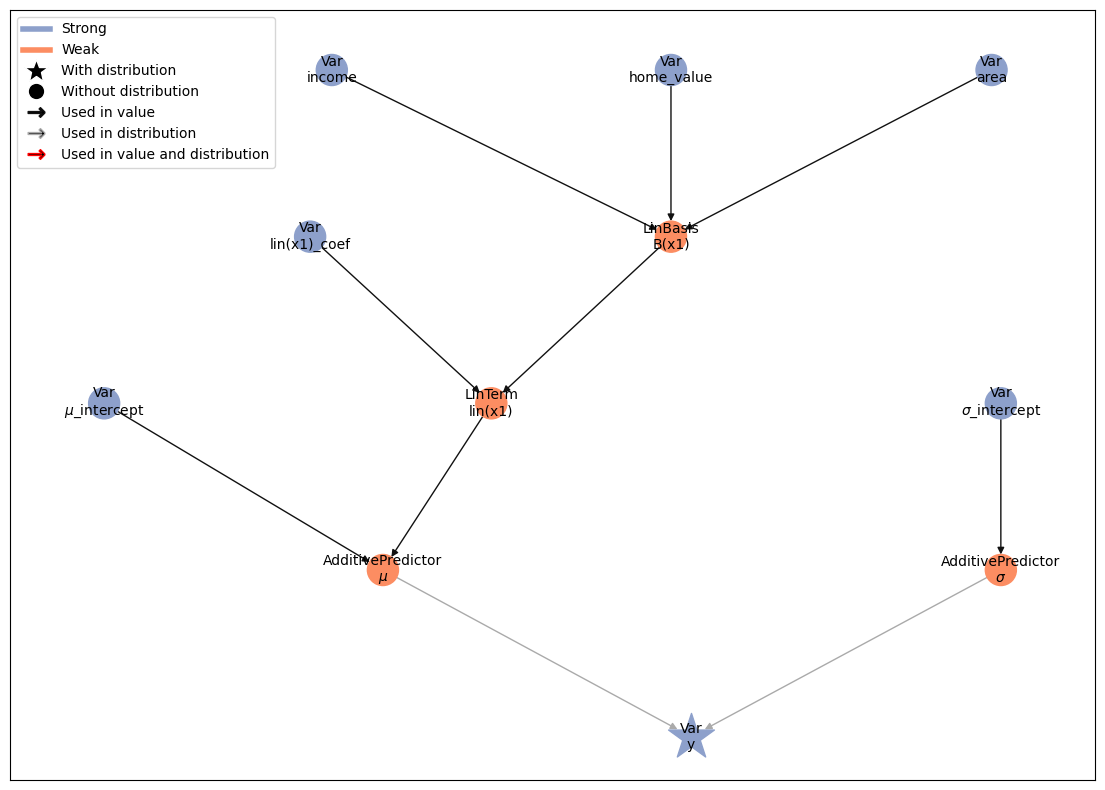

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=4000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', 'lin(x1)_coef'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  5.59chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1091.41chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 0, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1384.03chunk/s]
liesel.

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel       mean        sd     q_0.05  \
parameter          index                                              
$\mu$_intercept    ()     kernel_01  45.552750  4.320233  38.391793   
$\sigma$_intercept ()     kernel_00   2.442529  0.107759   2.270274   
lin(x1)_coef       (0,)   kernel_02  -1.277545  1.927426  -4.508245   
                   (1,)   kernel_02  -9.320073  2.215940 -13.081219   
                   (2,)   kernel_02  -0.292979  0.105237  -0.468057   
                   (3,)   kernel_02   2.104628  1.813398  -0.902797   

                              q_0.5     q_0.95  sample_size     ess_bulk  \
parameter          index                                                   
$\mu$_intercept    ()     45.526350  52.675478         4000  1153.575712   
$\sigma$_intercept ()      2.440375   2.621587         4000  3398.564905   
lin(x1)_coef       (0,)   -1.310802   1.957792         4000  4132.678459   
                   (1,)   -9.299650  -5.737878         4000  2893.494172   
                   (2,)   -0.292631  -0.121730         4000  1067.351072   
                   (3,)    2.127348   5.071474         4000  3833.559069   

                             ess_tail      rhat  
parameter          index                         
$\mu$_intercept    ()     1961.666226  1.000076  
$\sigma$_intercept ()     3512.283104  0.999637  
lin(x1)_coef       (0,)   4141.699558  1.000895  
                   (1,)   3507.041423  1.001074  
                   (2,)   1908.162541  1.000836  
                   (3,)   4033.884039  1.000650  

Error summary:

                                                   count  relative
kernel    error_code error_msg           phase                    
kernel_00 90         nan acceptance prob warmup        3  0.000188
                                         posterior     0       0.0

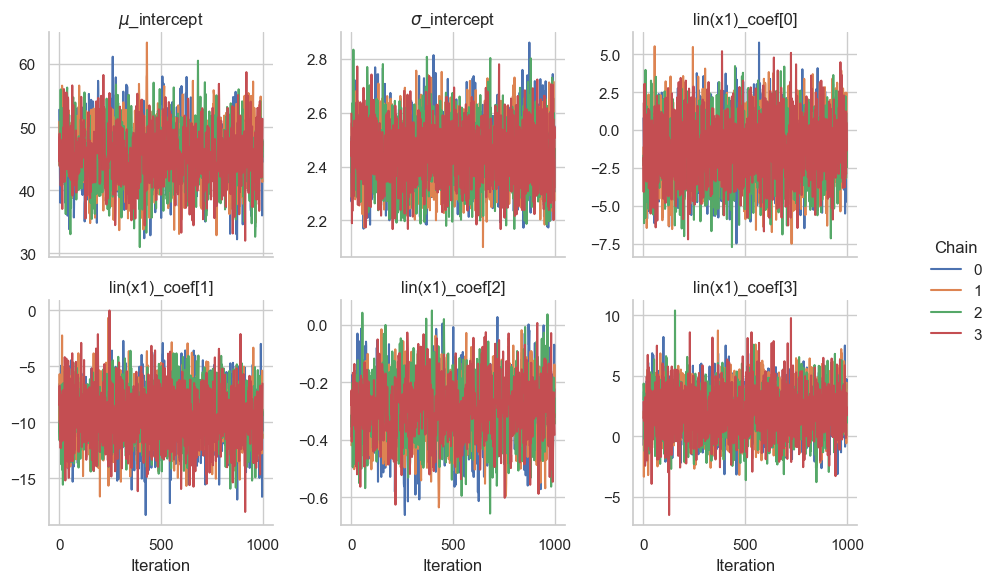

In [10]:
gs.plot_trace(results)

In [11]:
samples = results.get_posterior_samples()

In [12]:
gam.summarise_lin(model.vars["lin(x1)"], samples)

,x,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
0,scale(area),4000,-1.277545,3.714970,1.927426,4132.678459,4141.699558,0.029967,0.021962,1.000895,-4.508245,-1.310802,1.957792,-4.592783,1.813552
1,scale(income),4000,-9.320073,4.910390,2.215940,2893.494172,3507.041423,0.041195,0.028097,1.001074,-13.081219,-9.299650,-5.737878,-12.974682,-5.657604
2,home_value,4000,-0.292979,0.011075,0.105237,1067.351072,1908.162541,0.003220,0.001694,1.000836,-0.468057,-0.292631,-0.121730,-0.474566,-0.130287
3,scale(area):scale(income),4000,2.104628,3.288414,1.813398,3833.559069,4033.884039,0.029169,0.021340,1.000650,-0.902797,2.127348,5.071474,-1.022081,4.937158


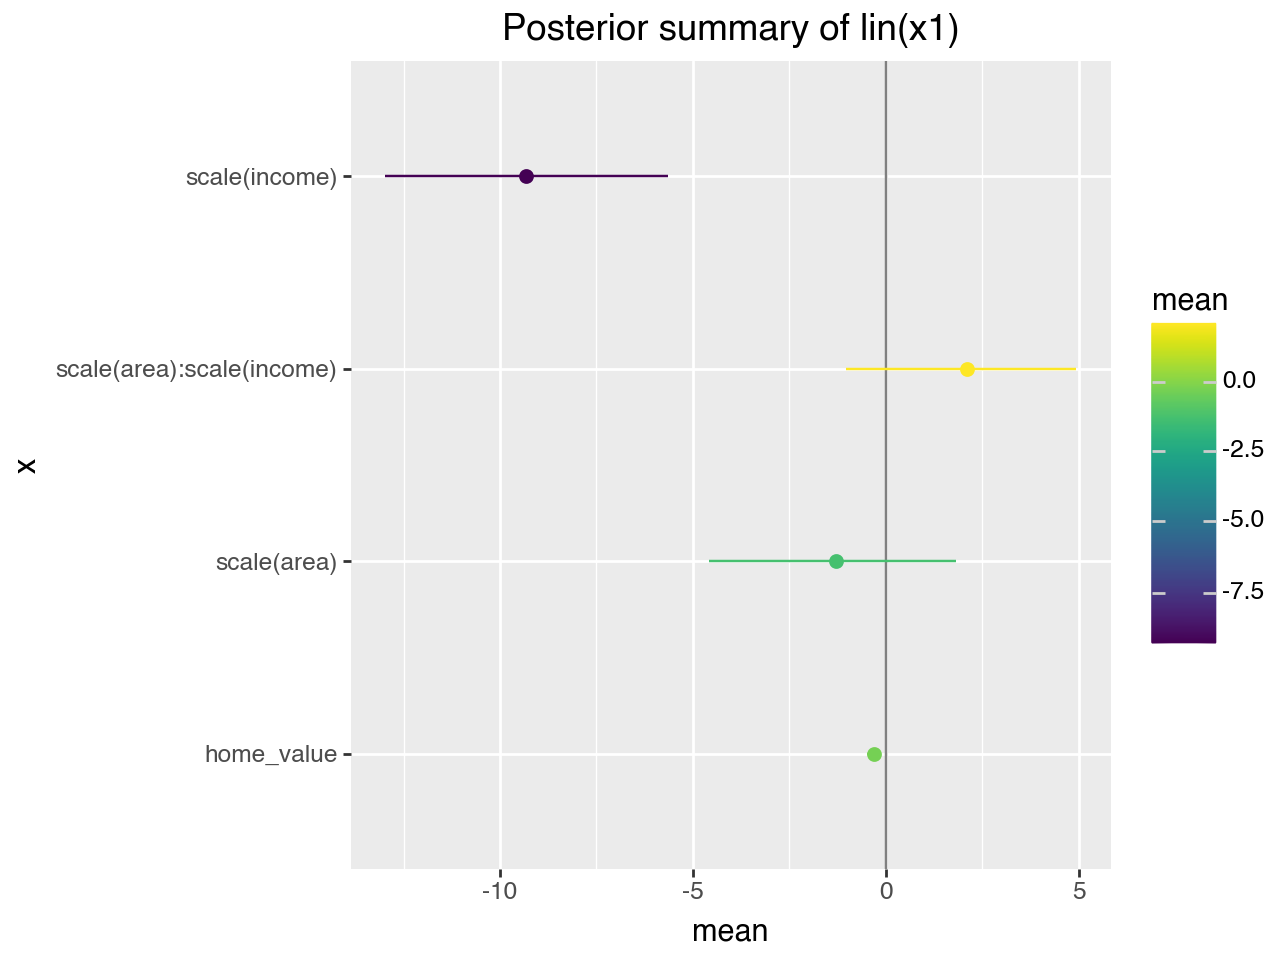

In [ ]:
term = model.vars["lin(x1)"]
gam.plot_forest(term, samples)